# Part 1: Scraping data from https://nanoreview.net/en/phone-list/antutu-rating

In [1]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select

from bs4 import BeautifulSoup
import requests
import time

import pandas as pd
import numpy as np
import datetime as dt 

import matplotlib.pyplot as plt 
import seaborn as sns


import pickle
import os

pd.options.display.max_columns=100
plt.style.use('ggplot')


headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
path=r"C:\Users\berid\python\Phone Specs Project"

In [2]:
driver=webdriver.Edge()
driver.maximize_window()

start_page='https://nanoreview.net/en/phone-list/antutu-rating'

driver.get(start_page)

In [3]:
all_phone_urls=[]
while True:
    phone_url_elements=driver.find_elements(By.CSS_SELECTOR,'table[class="table-list "] tbody tr')
    for phone_url_element in phone_url_elements:
        try:
            phone_url=phone_url_element.find_element(By.CSS_SELECTOR,'td a').get_attribute('href')
            all_phone_urls.append(phone_url)
        except:
            continue
    
    try:
        next_page=WebDriverWait(driver,3).until(expected_conditions.element_to_be_clickable((By.CSS_SELECTOR,'div[class="pagination-next-page"] span[class="button-light"]')))
        next_page.click()
        time.sleep(2)
    except:
        break

all_phone_urls=list(set(all_phone_urls))
print(len(all_phone_urls))

driver.quit()

663


In [4]:
def return_specs_dict(phone_url):

    #benchmarks part
    html=requests.get(phone_url,headers=headers).content
    soup=BeautifulSoup(html,'html.parser')

    specs_dict={}

    try:
        phone=soup.select_one('h1[class="title-h2"]').text.replace('Benchmarks','').strip()
        specs_dict['Phone']=phone
    except:
        specs_dict['Phone']=None

    benchmark_rows=soup.select('div[class="card benchmarks-main-specs"] tbody tr')
    for benchmark_row in benchmark_rows:
        try:
            label=benchmark_row.select_one('td[class="cell-h"]').text
            value=benchmark_row.select_one('td[class="cell-s"]').text
            specs_dict[label]=value
        except:
            continue


    #specs part
    phone_specs_url='/'.join(['phone' if i=='benchmark-ranking' else i for i in str(phone_url).split('/')])

    html=requests.get(phone_specs_url,headers=headers).content
    soup=BeautifulSoup(html,'html.parser')

    spec_rows=soup.select('article[id="the-app"] div[class="card"] table[class="specs-table"] tr')
    for spec_row in spec_rows:
        try:
            label=spec_row.select_one('td[class="cell-h"]').text
            value=spec_row.select_one('td[class="cell-s"]').text
            specs_dict[label]=value
        except:
            continue


    #soc comments part
    soc_url='/'.join(['soc' if i=='benchmark-ranking' else i for i in str(phone_url).split('/')])

    html=requests.get(soc_url,headers=headers).content
    soup=BeautifulSoup(html,'html.parser')

    soc_comments=[]
    try:
        comment_elements=soup.select('div[class="comments-container"] div[class="card-block flex pb comment-container"] div[class="comment-text"]')
    except:
        comment_elements=[]

    for comment_element in comment_elements:
        try:
            comment_text=comment_element.text.replace('\n','').replace('\r','')
            soc_comments.append(comment_text)
        except:
            continue
    specs_dict['SOC Comments']=soc_comments
            


    return specs_dict

In [6]:
all_data=[]

for i, phone_url in enumerate(all_phone_urls,start=1):
    specs_dict=return_specs_dict(phone_url)
    all_data.append(specs_dict)

    print(f'{i}/{len(all_phone_urls)}',end='\r')

In [7]:
df=pd.DataFrame(all_data)
#df.to_csv(os.path.join(path,'nanoreview_phone_specs.csv'),index=False)

# Part 2: Preprocessing

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns


import os

pd.options.display.max_columns=200
plt.style.use('ggplot')

path=r"C:\Users\berid\python\Phone Specs Project"

In [2]:
df=pd.read_csv(os.path.join(path,'nanoreview_phone_specs.csv'))

In [3]:
df.isna().mean().sort_values(ascending=False)

Additional lens     0.977376
Video               0.932127
Photo               0.932127
Bokeh               0.834087
Preview             0.834087
                      ...   
Total score         0.000000
Number of SIM*      0.000000
Type of SIM card    0.000000
Category            0.000000
Phone               0.000000
Length: 140, dtype: float64

In [4]:
nan_cols=df.columns[df.isna().mean()>0.75]
print(nan_cols)

df=df.drop(columns=nan_cols)

Index(['Bokeh', 'Preview', 'Samples', 'Photo', 'Video', 'DisplayPort',
       'Additional lens'],
      dtype='object')


In [5]:
df.select_dtypes(object).nunique().sort_values(ascending=False)

Phone                    663
Total Score              656
4G network               353
Height                   274
Watching video           271
                        ... 
Speakers                   2
Headphone audio jack       2
Depth sensor (TOF 3D)      2
Type of SIM card           1
SOC Comments               1
Length: 116, dtype: int64

In [6]:
df['Total Score']=df['Total Score'].str.replace(',','').apply(pd.to_numeric,errors='coerce')

In [7]:
display_size=df['Size'].apply(lambda x:x.split('inches')[0]).apply(pd.to_numeric)

df.insert(df.columns.get_loc('Size')+1,'Display Size',display_size)
df=df.drop(columns=['Size'])

In [8]:
x=df['Resolution'].apply(lambda x:x.replace('pixels','').split('x')[0]).apply(pd.to_numeric,errors='coerce')
y=df['Resolution'].apply(lambda x:x.replace('pixels','').split('x')[-1]).apply(pd.to_numeric,errors='coerce')


df.insert(df.columns.get_loc('Resolution')+1,'Pixels_X',x)
df.insert(df.columns.get_loc('Resolution')+2,'Pixels_Y',y)
df=df.drop(columns='Resolution')
df=df.drop(columns='Aspect ratio') #we dont need this column, since we have information on pixels

In [9]:
df['PPI']=df['PPI'].apply(lambda x:x.split(' ')[0]).apply(pd.to_numeric)

In [10]:
df['Refresh rate']=df['Refresh rate'].apply(lambda x:x.split(' ')[0]).apply(pd.to_numeric)

In [11]:
df['Adaptive refresh rate']=df['Adaptive refresh rate'].apply(lambda x: 1 if 'Yes' in str(x) else 0)

In [12]:
df['Max rated brightness']=df['Max rated brightness'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)

In [13]:
df['HDR support']=df['HDR support'].apply(lambda x: 1 if 'Yes' in str(x) else 0)

In [14]:
df['Touch sampling rate']=df['Touch sampling rate'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)

In [15]:
ratio=df['Screen-to-body ratio'].apply(lambda x:x.replace('%',''))  
df.insert(df.columns.get_loc('Screen-to-body ratio')+1,'Screen-to-body ratio (%)',ratio)
df=df.drop(columns='Screen-to-body ratio')

In [16]:
for col in ['Height','Width','Thickness']:
    values=df[col].apply(lambda x: x.split('mm')[0]).apply(pd.to_numeric,errors='coerce')
    df.insert(df.columns.get_loc(col)+1,f'{col} (mm)',values)
    df=df.drop(columns=col)

In [17]:
weight=df['Weight'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df.insert(df.columns.get_loc('Weight')+1,'Weight (gr)',weight)
df=df.drop(columns='Weight')

In [18]:
df=df.drop(columns='Colors')

In [19]:
df=df.drop(columns=['Chipset','Max clock','CPU cores','Architecture']) #CPU benchmarks is better predictor

In [20]:
l3=df['L3 cache'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df.insert(df.columns.get_loc('L3 cache')+1,'L3 cache (mb)',l3)
df['L3 cache (mb)'].fillna(0)
df=df.drop(columns='L3 cache')

In [21]:
Lithography=df['Lithography process'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df.insert(df.columns.get_loc('Lithography process')+1,'Lithography process (nm)',Lithography)
df=df.drop(columns='Lithography process')

In [22]:
df['Neural processor (NPU)']=df['Neural processor (NPU)'].apply(lambda x: 1 if 'No' not in str(x) else 0)

In [23]:
df=df.drop(columns=['Graphics','GPU shading units','GPU clock','FLOPS']) #GPU benchmarks is better predictor

In [24]:
ram=df['RAM size'].apply(lambda x:x.split(',')[0].split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df.insert(df.columns.get_loc('RAM size')+1,'RAM size (GB)',ram)
df=df.drop(columns='RAM size')

In [25]:
df['Memory clock']=df['Memory clock'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)

In [26]:
df['Channels']=df['Channels'].apply(pd.to_numeric,errors='coerce')

In [27]:
Storage=df['Storage size'].apply(lambda x:x.split(',')[0].split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df.insert(df.columns.get_loc('Storage size')+1,'Storage size (GB)',Storage)
df=df.drop(columns='Storage size')

In [28]:
current_os=df['Operating system'].apply(lambda x:x.split('(')[0].strip().split(' ')[-1].strip().split('.')[0]).apply(pd.to_numeric,errors='coerce')
max_os=df['Operating system'].apply(lambda x:x.split(' ')[-1].replace(')','')).apply(pd.to_numeric,errors='coerce')

os_support=(max_os-current_os)

df.insert(df.columns.get_loc('Operating system')+1,'OS suppoert (years)',os_support)
df=df.drop(columns='Operating system')

In [29]:
df=df.drop(columns='ROM')

In [30]:
df['Capacity']=df['Capacity'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Capacity':'Battery capacity (mAh)'})

In [31]:
df['Max charge power']=df['Max charge power'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)


In [32]:
df=df.rename(columns={'Replaceable':'Battery replaceability'})

In [33]:
df['Wireless charging']=df['Wireless charging'].apply(lambda x: 1 if 'Yes' in str(x) else 0)
df['Reverse charging']=df['Reverse charging'].apply(lambda x: 1 if 'Yes' in str(x) else 0)
df['Fast charging']=df['Fast charging'].apply(lambda x: 1 if 'Yes' in str(x) else 0)

In [34]:
df['Full charging time']=df['Full charging time'].apply(lambda x: 60*int(x.split(':')[0]) + int(x.split(':')[-1].split('hr')[0]) if isinstance(x,str) else None)
df=df.rename(columns={'Full charging time':'Full charging time (min)'})

df['Web browsing']=df['Web browsing'].apply(lambda x: 60*int(x.split(':')[0]) + int(x.split(':')[-1].split('hr')[0]) if isinstance(x,str) else None)
df=df.rename(columns={'Web browsing':'Web browsing (min)'})

df['Watching video']=df['Watching video'].apply(lambda x: 60*int(x.split(':')[0]) + int(x.split(':')[-1].split('hr')[0]) if isinstance(x,str) else None)
df=df.rename(columns={'Watching video':'Watching video (min)'})

df['Gaming']=df['Gaming'].apply(lambda x: 60*int(x.split(':')[0]) + int(x.split(':')[-1].split('hr')[0]) if isinstance(x,str) else None)
df=df.rename(columns={'Gaming':'Gaming (min)'})

In [35]:
df['Standby']=df['Standby'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Standby':'Standby (hr)'})

In [36]:
df['Matrix']=df['Matrix'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Matrix':'Matrix (megapixels)'})

df=df.drop(columns='Image resolution')

In [37]:
df['Zoom']=df['Zoom'].apply(lambda x: 'Optical' if 'Optical' in str(x) else 'Digital')

In [38]:
df['Angle of widest lens']=df['Angle of widest lens'].apply(lambda x:x.split('°')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Angle of widest lens':'Angle of widest lens (°)'})

In [39]:
df['Aperture']=df['Aperture'].apply(lambda x:x.split('/')[-1] if isinstance(x,str) else None).apply(pd.to_numeric)

In [40]:
df['Sensor size']=df['Sensor size'].apply(lambda x:x.split('/')[-1].replace('"','') if isinstance(x,str) else None).apply(pd.to_numeric)

In [41]:
df['Pixel size']=df['Pixel size'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Pixel size':'Pixel size (micron)'})

In [42]:
df['Megapixels']=df['Megapixels'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Megapixels':'Front camera megapixels'})

In [43]:
unncessary_cols=df.columns[df.columns.str.contains('Wi-Fi|Bluetooth|USB|GPS')]
df=df.drop(columns=unncessary_cols)

print(unncessary_cols)

Index(['Wi-Fi standard', 'Wi-Fi features', 'Bluetooth version',
       'Bluetooth features', 'USB type', 'USB version', 'USB features', 'GPS'],
      dtype='object')


In [44]:
df['Category'].value_counts()

Category
Mid-range    305
Flagship     247
Budget       111
Name: count, dtype: int64

In [45]:
df=df.drop(columns='Announced',errors='ignore')
df['Release date']=pd.to_datetime(df['Release date'])

today=dt.datetime.today()

phone_age_in_days = (today - df['Release date']).dt.days

df.insert(df.columns.get_loc('Release date')+1,'Phone age in days', phone_age_in_days)
df=df.drop(columns='Release date')


C:\Users\berid\AppData\Local\Temp\ipykernel_5988\1677709495.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release date']=pd.to_datetime(df['Release date'])


In [46]:
df['Launch price']=df['Launch price'].str.replace('$','').apply(pd.to_numeric)
df=df.rename(columns={'Launch price':'Launch price ($)'})

In [47]:
df['Sensors']=df['Sensors'].apply(lambda x:[i.strip() for i in x.split('-') if i.strip()!=''])
print(df['Sensors'][0])

sensor_dummies = df['Sensors'].apply(lambda x: pd.Series(1, index=x)).fillna(0)
df=pd.concat([df,sensor_dummies],axis=1)

df=df.drop(columns='Sensors')

['Proximity sensor', 'Gyroscope', 'Accelerometer', 'Ambient light sensor', 'Compass', 'Fingerprint']


In [48]:
df['Bundled charger']=df['Bundled charger'].apply(lambda x: 1 if 'Yes' in str(x) else 0)

In [49]:
df=df.drop(columns='SOC Comments',errors='ignore')

In [50]:
df['Max rated brightness in HDR']=df['Max rated brightness in HDR'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Max rated brightness in HDR':'Max rated brightness in HDR (nits)'})

In [51]:
df['RGB color space']=df['RGB color space'].str.replace('%','').apply(pd.to_numeric)
df=df.rename(columns={'RGB color space':'RGB color space (%)'})

In [52]:
df['PWM']=df['PWM'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric, errors='coerce')

In [53]:
df['Response time']=df['Response time'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Response time':'Front camera Response time (ms)'})

In [54]:
df=df.drop(columns=['Contrast','OS size'])

In [55]:
df['Focal length']=df['Focal length'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Focal length':'Front camera Focal length (mm)'})

In [56]:
df['LTE Cat*']=df['LTE Cat*'].apply(pd.to_numeric)

In [57]:
df=df.drop(columns=['2G network','3G network','4G network'])

In [58]:
df['Max surface temperature']=df['Max surface temperature'].apply(lambda x:x.split('°C')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Max surface temperature':'Front camera Max surface temperature (C)'})

In [59]:
df['Stability']=df['Stability'].apply(lambda x:x.split('%')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Stability':'Front camera Stability (%)'})

In [60]:
df['Graphics test']=df['Graphics test'].apply(lambda x:x.split(' ')[0] if isinstance(x,str) else None).apply(pd.to_numeric)
df=df.rename(columns={'Graphics test':'Front camera Graphics test (FPS)'})

In [61]:
df[['Graphics score','Web score','Video editing','Photo editing','Data manipulation','Writing score']]=df[['Graphics score','Web score','Video editing','Photo editing','Data manipulation','Writing score']].apply(pd.to_numeric)

In [62]:
df=df.drop(columns=['Memory card max size','SAR (head)','SAR (body)'])

In [63]:
columns_with_many_labels=df.select_dtypes(object).nunique()[(df.select_dtypes(object).nunique().sort_values(ascending=False)>=10)].index
columns_with_many_labels=list(columns_with_many_labels)
columns_with_many_labels.remove('Phone')
columns_with_many_labels.remove('Waterproof')
print(columns_with_many_labels)

df=df.drop(columns=columns_with_many_labels)

['Screen protection', 'Screen-to-body ratio (%)', 'Slow motion', 'Lenses', 'Sensor']


In [64]:
brand=df['Phone'].apply(lambda x:x.split(' ')[0])
df.insert(df.columns.get_loc('Phone')+1,'Brand',brand)
df=df.drop(columns='Phone')

In [65]:
df.to_csv(os.path.join(path,'nanoreview_phone_specs (processed).csv'),index=False)


# ML

In [2]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns


import os

pd.options.display.max_columns=200
plt.style.use('ggplot')

path=r"C:\Users\berid\python\Phone Specs Project"

In [3]:
df=pd.read_csv(os.path.join(path,'nanoreview_phone_specs (processed).csv'))

# Additional Preprocessing

C:\Users\berid\AppData\Local\Temp\ipykernel_13808\3051505887.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


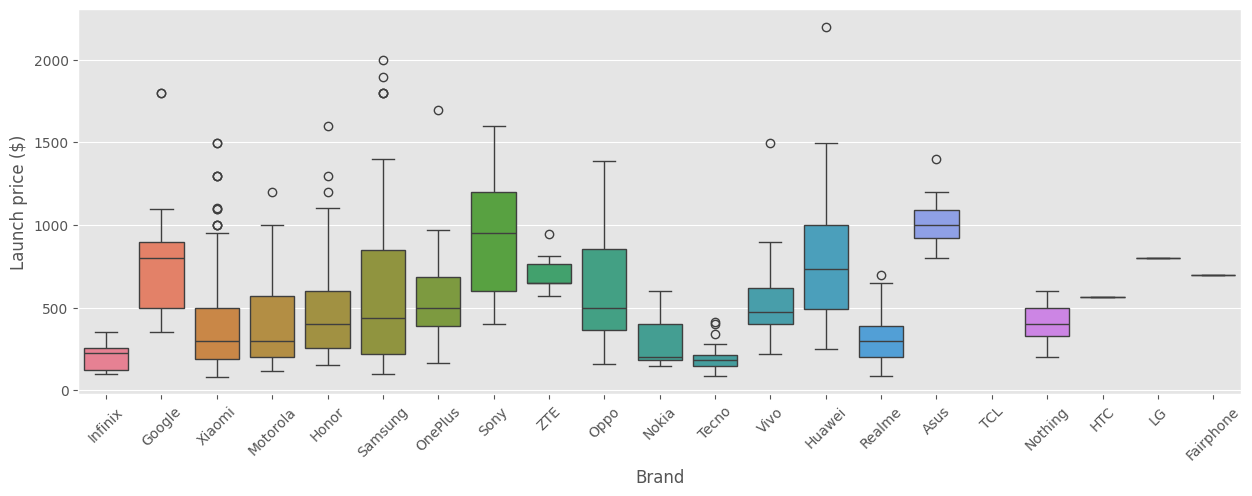

In [4]:
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(df,x='Brand',y='Launch price ($)',hue='Brand',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()


In [5]:
df.select_dtypes([int,float]).corr()['Launch price ($)'].sort_values(ascending=False)

Launch price ($)                   1.000000
Pixels_X                           0.729947
Wireless charging                  0.683056
RAM size (GB)                      0.649724
LTE Cat*                           0.634001
                                     ...   
Standby (hr)                      -0.324859
Full charging time (min)          -0.388366
Lithography process (nm)          -0.449749
Front camera Response time (ms)   -0.466556
Front camera Stability (%)        -0.563062
Name: Launch price ($), Length: 72, dtype: float64

In [6]:
#get dummies

for col in df.select_dtypes(object):
    dummies=pd.get_dummies(df[col],prefix=col,dummy_na=False)
    df=df.drop(columns=col)
    df=pd.concat([df,dummies],axis=1)

df.shape

(663, 221)

In [7]:
df=df[df['Launch price ($)'].notna()]
df=df.reset_index(drop=True)


# Train And Test ML Model

In [8]:
X=df.drop(columns='Launch price ($)')
y=df['Launch price ($)']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.25)

In [9]:
from xgboost import XGBRegressor

In [10]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model):
    train_sizes,train_scores,test_scores=learning_curve(
        X=X_train,
        y=y_train,
        estimator=model,
        train_sizes=np.linspace(0.1,1,10),
        cv=3,
        scoring='neg_root_mean_squared_error',
        verbose=1
    )
    
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy', color='red')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='red')
    plt.xlabel('Training Set Size')
    plt.ylabel('MAE')
    plt.title('Learning Curve for XGBoost Classifier')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

[learning_curve] Training set sizes: [ 32  64  96 128 161 193 225 257 289 322]


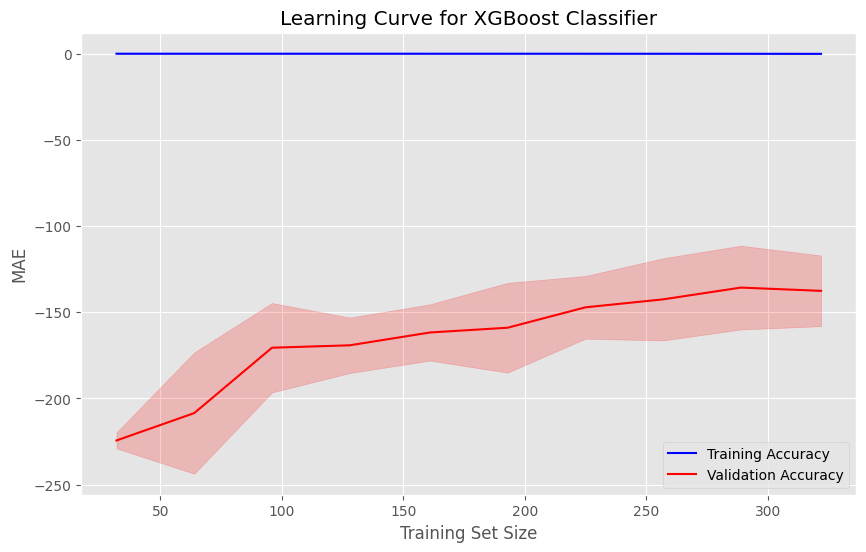

In [11]:
plot_learning_curve(XGBRegressor()) #initial model

In [12]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators':[100,500,1000,2000],
            'max_depth':[3,5,8,10],
            'learning_rate':[0.01,0.05,0.1,0.15]}

grid_search_cv=GridSearchCV(estimator=XGBRegressor(),
                         param_grid=param_grid,
                         scoring='neg_root_mean_squared_error',
                         cv=3,
                         verbose=10)

grid_search_cv.fit(X_train,y_train)

best_model=grid_search_cv.best_estimator_
print(grid_search_cv.best_estimator_)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-193.493 total time=   0.5s
[CV 2/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-183.292 total time=   0.3s
[CV 3/3; 1/64] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 3/3; 1/64] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-198.982 total time=   0.4s
[CV 1/3; 2/64] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[CV 1/3; 2/64] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-111.187 total time=   1.0s
[CV 2/3; 2/64] START learning_rate=0.01, max_depth=3, n_estimators=500..........
[CV 2/3; 2/64] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-130.562 total time=   1.1s
[CV 3/3;

[learning_curve] Training set sizes: [ 32  64  96 128 161 193 225 257 289 322]


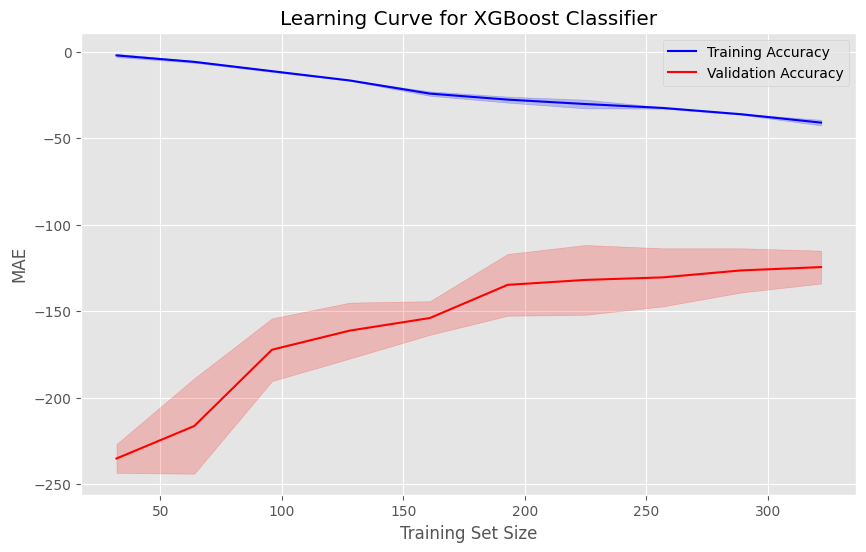

In [13]:
plot_learning_curve(best_model)

# less overfitting

In [14]:
train_prediction=best_model.predict(X_train)
test_prediction=best_model.predict(X_test)

In [15]:
from sklearn import metrics

r2_train=metrics.r2_score(train_prediction,y_train)
r2_test=metrics.r2_score(test_prediction,y_test)
mae_train=metrics.mean_absolute_error(train_prediction,y_train)
mae_test=metrics.mean_absolute_error(test_prediction,y_test)
rmse_train=metrics.mean_squared_error(train_prediction,y_train,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,y_test,squared=False)
train_scores={'R2_train':r2_train,'MAE_train':mae_train,'RMSE_train':rmse_train}
test_scores={'R2_test':r2_test,'MAE_test':mae_test,'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)

{'R2_train': 0.9773853333253657, 'MAE_train': 39.80947458966178, 'RMSE_train': 52.08772050843419}
{'R2_test': 0.8980120203130421, 'MAE_test': 75.63517926063066, 'RMSE_test': 116.06681609326623}


C:\Users\berid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\berid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Error Analysis

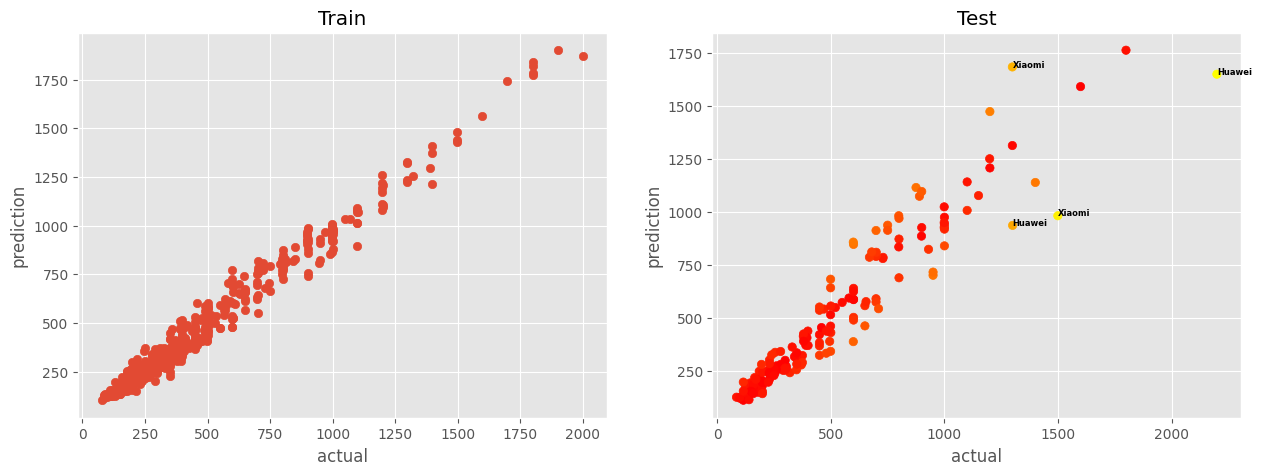

In [16]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(y_train,train_prediction)
ax1.set_xlabel('actual')
ax1.set_ylabel('prediction')
ax1.set_title('Train')
ax2.scatter(y_test,test_prediction,c=(y_test-test_prediction).abs(),cmap='autumn')
ax2.set_xlabel('actual')
ax2.set_ylabel('prediction')
ax2.set_title('Test')


brands=X_test[X_test.columns[X_test.columns.str.contains('Brand_')]].idxmax(axis=1).str.replace('Brand_','')
absolute_error=(y_test-test_prediction).abs()
#plot text
for error,actual,prediction,brand in zip(absolute_error,y_test,test_prediction,brands):
    if error<mae_test-2*rmse_test or error>mae_test+2*rmse_test:
        ax2.text(actual,prediction,brand,fontweight='bold',size=6)
    
plt.show()

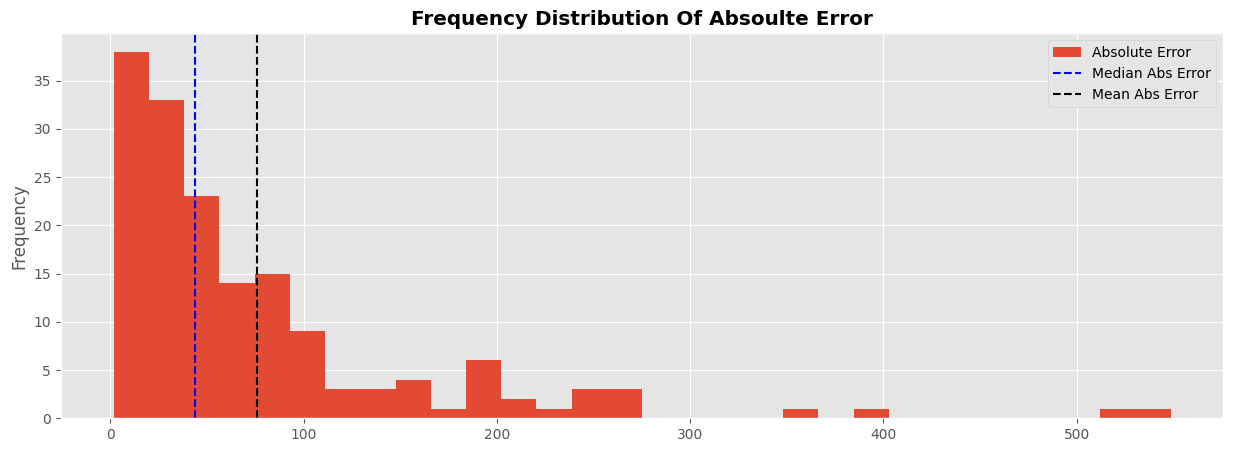

In [17]:
fig,ax=plt.subplots(figsize=(15,5))
absolute_error.plot.hist(ax=ax,bins=30,label='Absolute Error')
ax.set_title('Frequency Distribution Of Absoulte Error',fontweight='bold')
median_abs_error=absolute_error.median()
ax.axvline(median_abs_error,label='Median Abs Error',color='blue',ls='--')
ax.axvline(mae_test,label='Mean Abs Error',color='black',ls='--')
ax.legend()
plt.show()

In [ ]:
import subprocess

subprocess.run(['nbmerge', 'scrape.ipynb', 'cleaning.ipynb', 'EDA.ipynb', '-o', 'combined_notebook.ipynb'], check=True)